In [5]:
%pip install zennit

Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import sys
import numpy as np
import PIL
from PIL import Image
import torch
from captum.attr import LayerGradCam, visualization , LRP
from torchvision.transforms import ToTensor, Normalize, Compose

# Append custom paths to sys.path for importing custom modules
sys.path.append(os.path.dirname("/home/student/Desktop/31171109-donotdelete/xai-chan/utils"))
from utils.models import ResNet_Model
from utils.transform import resize_transform

# Initialize device
device = torch.device('cuda:0')

In [16]:
# Load model
version = 50
downstream_task_model = ResNet_Model(version=version).to(device)
weights_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/result/imagenet/_Fold_0_5_100X_BreakHis_FT_60_resnet50_imagenet_/_97_94.94949494949495_95.2628090863385_0.9500590562820435.pth"  # TODO: Provide the model path
downstream_task_model.load_state_dict(torch.load(weights_path, map_location=device))
downstream_task_model.eval()

ResNet_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [25]:
# Prepare input
# image_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/dataset/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png"  # TODO: Provide the image path
# image_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/dataset/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-001.png"
image_path ="/home/student/Desktop/31171109-donotdelete/xai-chan/dataset/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-001.png"
input_rgb = Image.open(image_path)
width, height = input_rgb.size
# print(f"Width: {width}, Height: {height}")
input_tensor = resize_transform(np.array(input_rgb)).unsqueeze(0).to(device)

outputs = downstream_task_model(input_tensor)
target_category = (outputs > 0.2).int().item()
print(target_category)

0


In [56]:


# Compute GradCAM using Captum
target_layer = downstream_task_model.model.layer4[-1]
grad_cam = LayerGradCam(downstream_task_model, target_layer)
# Get class with maximum output as target for GradCAM
outputs = downstream_task_model(input_tensor)
target_category = (outputs > 0.2).int().item()
print(target_category)

attributions_gc = grad_cam.attribute(input_tensor, target=None)

# Visualize and save
upsampled_attr = LayerGradCam.interpolate(attributions_gc, (460, 700))  # Upsample to input image size


1


In [46]:
from captum.attr import LRP
from captum.attr._core.lrp import EpsilonRule

for _, module in downstream_task_model.named_modules():
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.BatchNorm2d, torch.nn.ReLU)):
        module.rule = EpsilonRule()

# Now, you can use LRP
lrp = LRP(downstream_task_model)
attributions = lrp.attribute(input_tensor, target=target_category)
upsampled_attr = LayerGradCam.interpolate(attributions, input_rgb.size[::-1])  # Ensure size is (W, H)


TypeError: Module of type <class 'torch.nn.modules.activation.Sigmoid'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

In [48]:
from captum.attr._core.lrp import EpsilonRule

def set_rules_for_lrp(model):
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.BatchNorm2d, torch.nn.ReLU, torch.nn.MaxPool2d)):
            module.rule = EpsilonRule()

# Apply the function to your model
set_rules_for_lrp(downstream_task_model)


In [49]:
# Now, you can use LRP
lrp = LRP(downstream_task_model)
attributions = lrp.attribute(input_tensor, target=target_category)
upsampled_attr = LayerGradCam.interpolate(attributions, input_rgb.size[::-1])  # Ensure size is (W, H)

AttributeError: 'NoneType' object has no attribute 'relevance_input'

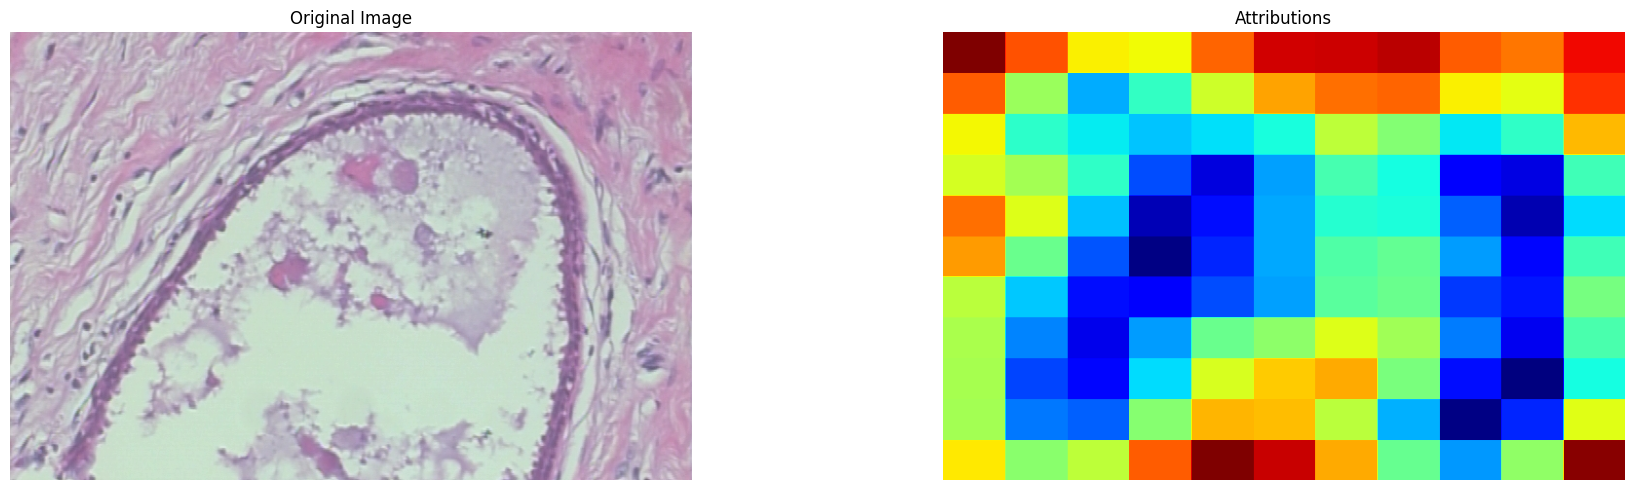

In [24]:
import matplotlib.pyplot as plt

# Assuming you already have upsampled_attr from your previous code
attr_np = upsampled_attr[0].cpu().detach().permute(1,2,0).numpy()
attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min())  # Normalize to [0,1]

fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Original image
ax[0].imshow(np.array(input_rgb))
ax[0].axis('off')
ax[0].set_title('Original Image')

# Attribution heatmap
ax[1].imshow(attr_np, cmap='jet')
ax[1].axis('off')
ax[1].set_title('Attributions')

plt.tight_layout()
plt.show()


In [25]:
import cv2

def overlay_heatmap_on_image(image, heatmap, alpha=0.6, cmap='jet'):
    """
    Overlays a heatmap on an image and returns the combined image.
    
    Parameters:
    - image: PIL Image or NumPy array (H x W x C).
    - heatmap: NumPy array (H x W) or (H x W x C) if it's already a colored heatmap.
    - alpha: opacity of the heatmap overlay. Between 0 and 1.
    - cmap: colormap to use if heatmap is 2D.
    
    Returns:
    - Combined image with heatmap overlay.
    """
    # Convert PIL Image to numpy array
    if isinstance(image, PIL.Image.Image):
        image = np.array(image)

    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # If heatmap is 2D, colorize it using the given colormap
    if len(heatmap.shape) == 2:
        heatmap_colored = plt.cm.get_cmap(cmap)(heatmap)[:, :, :3]  # Drop alpha channel
    else:
        heatmap_colored = heatmap

    # Blend the images
    combined_image = image * (1 - alpha) + heatmap_colored * alpha
    combined_image = (combined_image * 255).astype(np.uint8)  # Convert from [0,1] to [0,255]
    
    return combined_image


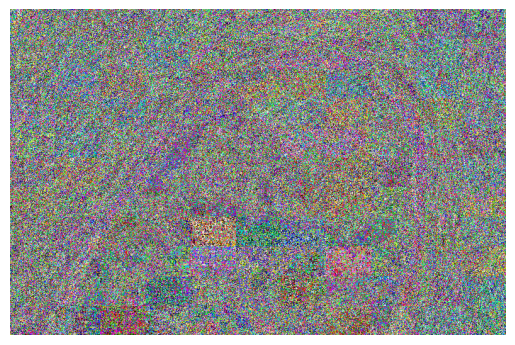

In [26]:




# Assuming you have upsampled_attr and input_rgb from your previous code
attr_np = upsampled_attr[0].cpu().detach().permute(1,2,0).numpy()
attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min())  # Normalize to [0,1]

overlay_image = overlay_heatmap_on_image(input_rgb, attr_np)

# Display the overlay image
plt.imshow(overlay_image)
plt.axis('off')
plt.show()


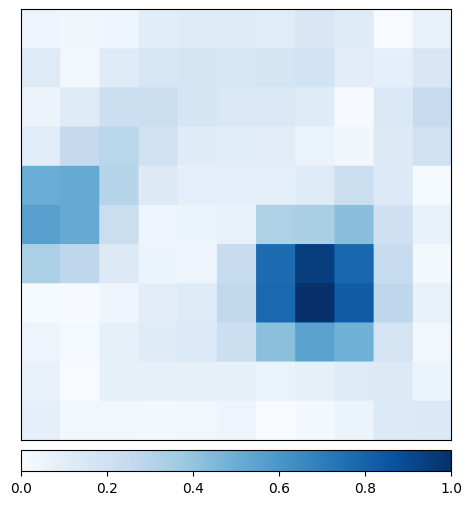

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

In [6]:
visualization.visualize_image_attr(upsampled_attr[0].cpu().detach().permute(1,2,0).numpy(), 
                                  method="heat_map", 
                                  original_image=np.array(input_rgb), 
                                  alpha_overlay=0.4, 
                                  show_colorbar=True)



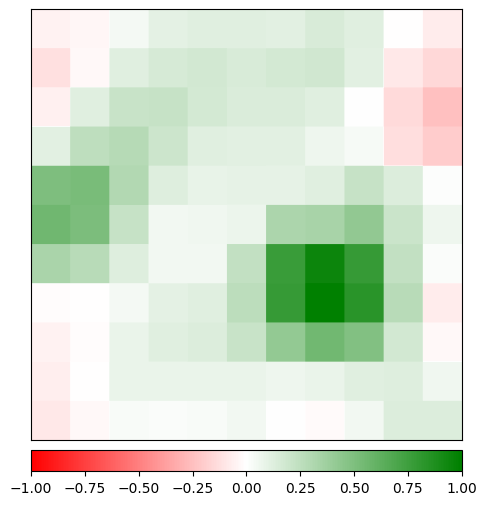

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

In [11]:
from captum.attr import visualization as viz

# Visualizing the heatmap overlaid on the original image
viz.visualize_image_attr(upsampled_attr[0].cpu().detach().permute(1, 2, 0).numpy(),
                         original_image=np.array(input_rgb),
                         method="heat_map",
                         sign="all",
                         alpha_overlay=0.1,
                         show_colorbar=True)



In [12]:
from PIL import Image

# Convert heatmap to PIL Image
heatmap_pil = Image.fromarray((upsampled_attr[0].cpu().detach().permute(1, 2, 0).numpy() * 255).astype(np.uint8))

# Resize the heatmap to the original image size
heatmap_resized = heatmap_pil.resize(input_rgb.size)

# Convert resized heatmap back to numpy array
heatmap_resized_np = np.array(heatmap_resized)

# Visualizing the heatmap overlaid on the original image
viz.visualize_image_attr(heatmap_resized_np,
                         original_image=np.array(input_rgb),
                         method="heat_map",
                         sign="all",
                         alpha_overlay=0.4,
                         show_colorbar=True)


TypeError: Cannot handle this data type: (1, 1, 1), |u1

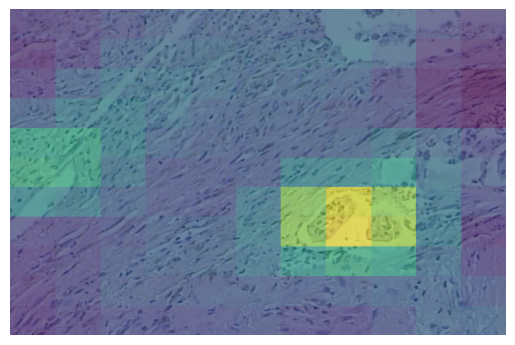

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_heatmap_on_image(original_image, heatmap):
    # Check and remove unnecessary dimension from heatmap
    if heatmap.ndim == 3 and heatmap.shape[2] == 1:
        heatmap = heatmap[:, :, 0]
    
    # Normalize heatmap to [0,1]
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Convert original_image to [0,1] range if it's in [0,255]
    if np.max(original_image) > 1.0:
        original_image = original_image / 255.0
    
    # Convert normalized heatmap to colormap (drop alpha channel with [:,:, :3])
    heatmap_colormap = plt.cm.viridis(heatmap_normalized)[:, :, :3]
    
    # Overlay images: here 0.7 specifies the transparency of the heatmap
    overlayed_image = (0.6 * heatmap_colormap + 0.3 * original_image)
    
    # Clip values to [0,1] in case some values ended up out of this range
    overlayed_image = np.clip(overlayed_image, 0, 1)
    
    return overlayed_image

# Assuming upsampled_attr is your heatmap and input_rgb is your original image
heatmap_np = upsampled_attr[0].cpu().detach().permute(1,2,0).numpy()
overlayed_img = overlay_heatmap_on_image(np.array(input_rgb), heatmap_np)

plt.imshow(overlayed_img)
plt.axis('off')
plt.show()


Prediction: 0.00021225518139544874


ValueError: Could not save to JPEG for display

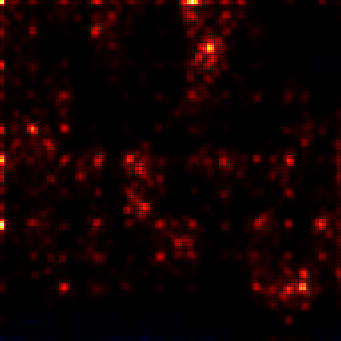

In [26]:
from zennit.image import imgify  # For creating visualizations
from zennit.torchvision import ResNetCanonizer  # For ResNet-specific canonization
from zennit.composites import EpsilonPlusFlat  # For the composite function in LRP
from zennit.attribution import Gradient  # For attributing using gradients
from IPython.display import display
# Make sure your model is in evaluation mode
downstream_task_model.eval()

# Use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# Create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

target = torch.tensor([[1.0]]).to(device)

# Create the attributor, specifying model and composite
with Gradient(model=downstream_task_model, composite=composite) as attributor:
    # Compute the model output and attribution
    output, attribution = attributor(input_tensor, target)

print(f'Prediction: {output.item()}')  # Adapted for a binary classification output

# Sum over the channels
relevance = attribution.sum(1).cpu()

# Create an image of the visualized attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')



# Convert the image to RGB mode and then display it
img.convert('RGB').show()

# Show the image
display(img)